In [1]:
import pickle
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import random
import clip
import torch
import time
from tqdm import tqdm

In [2]:
idx23_0 = pickle.load(open("/data/cc3m_embed/embed_cc3m_2023/order0.p","rb"))
idx23_1 = pickle.load(open("/data/cc3m_embed/embed_cc3m_2023/order1.p","rb"))
idx18_0 = pickle.load(open("/data/cc3m_embed/embed_cc3m_2018_b/order0.p","rb"))
idx18_1 = pickle.load(open("/data/cc3m_embed/embed_cc3m_2018_b/order1.p","rb"))
idx18 = idx18_0 + idx18_1
idx23 = idx23_0 + idx23_1
missing_indexes = np.array(list(set(idx18) - set(idx23)))
comparison = torch.from_numpy(np.load("/data/cc3m/cc3m_2023/embeddings/CC_vs_imagenet.npy")).cuda()
(max, max_indices) = torch.max(comparison,1)
max = max.cpu().numpy()
max_indices = max_indices.cpu().numpy()
cc_vs_imagenet = pd.DataFrame({'idx':range(len(max_indices)),'max':max, 'max_indices':max_indices}, index=range(len(max_indices)))

In [141]:
threshold_similarity = 0.6
threshold_sample = 30

In [142]:
#Only samples with similarity above threshold
cc_vs_imagenet_threshold = cc_vs_imagenet[cc_vs_imagenet['max']>threshold_similarity]

#Find the missing samples with similarity above threshold
cc_vs_imagenet_missing = cc_vs_imagenet.loc[missing_indexes-2]
cc_vs_imagenet_missing_threshold = cc_vs_imagenet_missing[cc_vs_imagenet_missing['max']>threshold_similarity]

#Find how many samples assigned to each class
missing_ind = np.zeros(1000, dtype='int32')
all_ind = np.zeros(1000, dtype='int32')
for i in range(len(cc_vs_imagenet_missing_threshold)):
    missing_ind[cc_vs_imagenet_missing_threshold['max_indices'].iloc[i]] += 1
for i in range(len(cc_vs_imagenet_threshold)):
    all_ind[cc_vs_imagenet_threshold['max_indices'].iloc[i]] += 1

imagenet_classes_threshold_similarity = pd.DataFrame({'idx':range(1000),'missing':missing_ind,'all':all_ind}, index=range(1000))

In [143]:
#Only consider the classes with at least threshold_sample sample assigned
imagenet_classes_threshold_ss = imagenet_classes_threshold_similarity[imagenet_classes_threshold_similarity['all']>threshold_sample]

#Find the percentage of missing samples
imagenet_classes_threshold_ss['percentage'] = imagenet_classes_threshold_ss['missing']/imagenet_classes_threshold_ss['all']

/tmp/ipykernel_3842867/2603003198.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  imagenet_classes_threshold_ss['percentage'] = imagenet_classes_threshold_ss['missing']/imagenet_classes_threshold_ss['all']


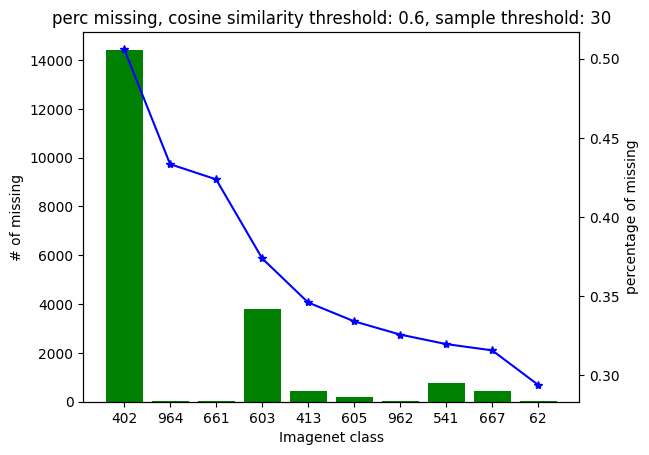

In [144]:
imagenet_classes_threshold_ss_perc = imagenet_classes_threshold_ss.sort_values('percentage',ascending=False)

fig, ax1 = plt.subplots()
ax1.bar([str(x) for x in imagenet_classes_threshold_ss_perc['idx'].values[0:10]],
        imagenet_classes_threshold_ss_perc[0:10]['missing'],
       color='g')
ax1.set_ylabel('# of missing')
ax1.set_xlabel('Imagenet class')
title = 'perc missing, cosine similarity threshold: ' + str(threshold_similarity) + ', sample threshold: ' + str(threshold_sample)
ax1.set_title(title)

ax2 = plt.twinx()
ax2.plot([str(x) for x in imagenet_classes_threshold_ss_perc['idx'].values[0:10]], 
           [x for x in imagenet_classes_threshold_ss_perc['percentage'].values[0:10]],
           color='b', marker='*')
#ax2.set_ylim(0.25, 0.45)
ax2.set_ylabel('percentage of missing')
name = 'perc'+str(int(threshold_similarity*10))+str(int(threshold_sample/10))
plt.savefig(name+'.png')
plt.show()

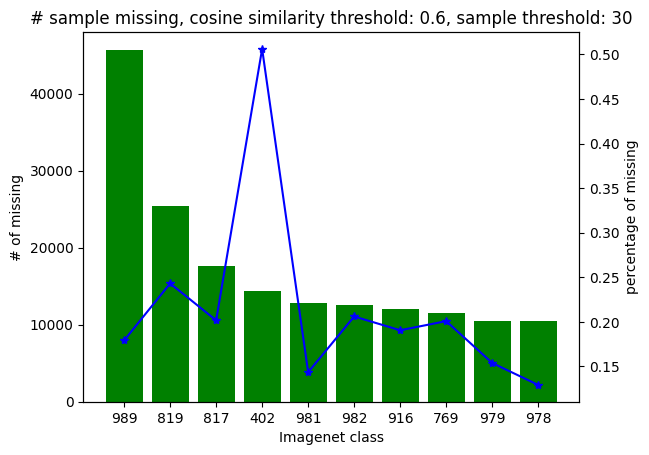

In [145]:
imagenet_classes_threshold_ss_miss = imagenet_classes_threshold_ss.sort_values('missing',ascending=False)

fig, ax1 = plt.subplots()
ax1.bar([str(x) for x in imagenet_classes_threshold_ss_miss['idx'].values[0:10]],
        imagenet_classes_threshold_ss_miss[0:10]['missing'],
       color='g')
ax1.set_ylabel('# of missing')
ax1.set_xlabel('Imagenet class')
title = '# sample missing, cosine similarity threshold: ' + str(threshold_similarity) + ', sample threshold: ' + str(threshold_sample)
ax1.set_title(title)

ax2 = plt.twinx()
ax2.plot([str(x) for x in imagenet_classes_threshold_ss_miss['idx'].values[0:10]], 
           [x for x in imagenet_classes_threshold_ss_miss['percentage'].values[0:10]],
           color='b', marker='*')
#ax2.set_ylim(0.1, 0.25)
ax2.set_ylabel('percentage of missing')
name = 'num'+str(int(threshold_similarity*10))+str(int(threshold_sample/10))
plt.savefig(name+'.png')
plt.show()